# Machine Learning models on Mismatch Response data

In this notebook: 
- Necessary imports
- SVM model 
- Logistic Regression model
- Decision Tree model

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import seaborn as sn
import matplotlib.pyplot as plt
import ipywidgets as widgets

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow import keras
from tensorflow.keras import layers

2022-11-04 15:44:24.984804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 15:44:25.092560: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-04 15:44:25.121681: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 15:44:25.661814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
csv = widgets.RadioButtons(
    options=['df_mmr_ch_complete.csv', 'df_mmr_ch_literature.csv', 'df_mmr_ch_ttest.csv', 'df_mmr_ch_connectivity.csv'],
    description='Pick sensors',
    disabled=False
)
display(csv)

RadioButtons(description='Pick sensors', options=('df_mmr_ch_complete.csv', 'df_mmr_ch_literature.csv', 'df_mm…

In [3]:
csv = str(csv.value)
csv

'df_mmr_ch_connectivity.csv'

In [4]:
df = pd.read_csv(csv, sep = ',')

In [5]:
if csv=='df_mmr_ch_ttest.csv' or csv=='df_mmr_ch_connectivity.csv':
    df = df[30:]

In [6]:
df

,Group_AccToParents,std_Fp1,std_Fp2,std_Fz,sur_Fp1,sur_Fp2,sur_Fz,min_Fp1,min_Fp2,min_Fz,max_Fp1,max_Fp2,max_Fz
30,0,0.000002,0.000003,0.000003,-0.001133,-0.005099,-0.003773,-0.000006,-0.000010,-0.000011,0.000005,0.000003,0.000003
31,1,0.000004,0.000004,0.000003,-0.004090,-0.003092,-0.002993,-0.000013,-0.000012,-0.000007,0.000004,0.000006,0.000004
32,1,0.000002,0.000003,0.000003,0.001824,0.007688,-0.002847,-0.000004,-0.000003,-0.000015,0.000005,0.000010,0.000005
33,1,0.000002,0.000002,0.000002,0.003218,0.000457,0.003571,-0.000004,-0.000004,-0.000004,0.000006,0.000004,0.000007
34,0,0.000003,0.000002,0.000002,-0.003450,-0.001075,-0.004012,-0.000006,-0.000006,-0.000007,0.000004,0.000004,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0.000002,0.000003,0.000001,-0.000240,-0.002848,-0.001568,-0.000007,-0.000008,-0.000004,0.000006,0.000005,0.000002
97,0,0.000002,0.000003,0.000003,0.000269,0.007656,0.006866,-0.000004,-0.000003,-0.000003,0.000005,0.000010,0.000009
98,1,0.000002,0.000003,0.000003,0.000997,-0.005320,-0.008796,-0.000005,-0.000009,-0.000011,0.000005,0.000004,0.000004
99,0,0.000003,0.000003,0.000002,0.000633,0.007501,0.003205,-0.000007,-0.000003,-0.000004,0.000008,0.000011,0.000005


In [7]:
dfcor = df.corr()

In [8]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcor, 10))

Top Absolute Correlations
std_Fp1  std_Fp2    0.981204
min_Fp1  min_Fp2    0.965985
sur_Fz   min_Fz     0.960426
std_Fz   min_Fz     0.947248
max_Fp1  max_Fp2    0.938917
sur_Fp1  sur_Fp2    0.935476
std_Fp2  std_Fz     0.901753
std_Fz   min_Fp2    0.894517
         min_Fp1    0.883679
std_Fp2  min_Fp2    0.882741
dtype: float64


## Split data

In [9]:
y = df['Group_AccToParents'].values # dependent variable
X = df.drop(['Group_AccToParents'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale data

In [10]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Select model

In [11]:
model_pick = widgets.RadioButtons(
    options=['SVM', 'Logistic Regression', 'Decision Tree', 'Multi Layer Perceptron', 'Convolutional Neural Network'],
    description='Pick model',
    disabled=False
)
display(model_pick)

RadioButtons(description='Pick model', options=('SVM', 'Logistic Regression', 'Decision Tree', 'Multi Layer Pe…

In [12]:
model_pick = str(model_pick.value)

## SVM model

In [13]:
svm = SVC()
parameters = {'kernel':('linear','poly', 'rbf', 'sigmoid'), 'C':[0.0001, 10000], 'gamma':('auto','scale')}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)
#sorted(clf.cv_results_.keys())

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.0001, 10000], 'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [14]:
clf.score(X_train, y_train)

0.5892857142857143

In [15]:
clf.best_params_

{'C': 0.0001, 'gamma': 'auto', 'kernel': 'linear'}

In [16]:
svm = SVC(C=10000, kernel=clf.best_params_.get('kernel'), gamma=clf.best_params_.get('gamma')) #C=0.0001, kernel='linear', gamma='auto', random_state=True
svm.fit(X_train, y_train)

SVC(C=10000, gamma='auto', kernel='linear')

In [17]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.400


In [18]:
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

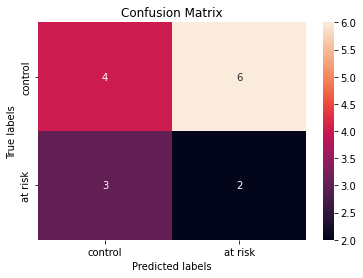

In [19]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [21]:
# with kfold cross validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = svm
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    print(pred_values)
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

[1 0 0 0 0 0 1 0 0 1 0 0 0 1 1]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 0 1 1 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 1 0 0 0]
accuracy of each fold - [0.6666666666666666, 0.7857142857142857, 0.5, 0.42857142857142855, 0.7857142857142857]
Avg accuracy : 0.6333333333333333


## Logistic Regression model

In [22]:
lr = LogisticRegression()
parameters = {'C':[500, 1000], 'max_iter': [4000,5000],
              'solver': ('liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga')} #'penalty':('l1', 'l2', 'elasticnet')
clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [500, 1000], 'max_iter': [4000, 5000],
                         'solver': ('liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga')})

In [23]:
lr = LogisticRegression(C=1000,
                       solver=clf.best_params_.get('solver'))
lr.fit(X_train, y_train)

LogisticRegression(C=1000, solver='liblinear')

In [24]:
y_pred = lr.predict(X_test)

In [25]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.786


In [26]:
len(y_pred)

14

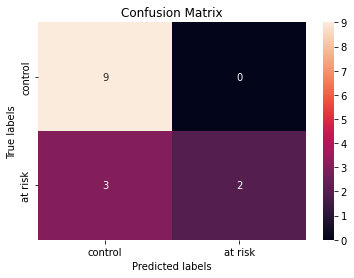

In [27]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [30]:
# with kfold cross validation
k = 5
kf = KFold(n_splits=k, shuffle = True, random_state=None)
model = lr
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    print(pred_values)
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 0 0]
[0 0 1 0 0 0 0 1 1 1 0 1 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
accuracy of each fold - [0.6666666666666666, 0.5714285714285714, 0.6428571428571429, 0.5, 0.6428571428571429]
Avg accuracy : 0.6047619047619047


## Decision Tree model

In [31]:
dt = tree.DecisionTreeClassifier()
parameters = {'criterion':('gini', 'entropy', 'log_loss'), 'splitter': ('random', 'best'), 'max_depth' : [2,20]}
clf = GridSearchCV(dt, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': [2, 20], 'splitter': ('random', 'best')})

In [32]:
dt = tree.DecisionTreeClassifier(criterion=clf.best_params_.get('criterion'), splitter=clf.best_params_.get('splitter'),
                                 max_depth=clf.best_params_.get('max_depth'))
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, splitter='random')

In [33]:
y_pred = dt.predict(X_test)

In [34]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.500


In [35]:
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

[Text(0.6704545454545454, 0.95, 'X[10] <= 0.0\nentropy = 0.973\nsamples = 57\nvalue = [34, 23]'),
 Text(0.4772727272727273, 0.85, 'X[7] <= -0.0\nentropy = 0.949\nsamples = 49\nvalue = [31, 18]'),
 Text(0.3181818181818182, 0.75, 'X[3] <= -0.001\nentropy = 0.837\nsamples = 30\nvalue = [22, 8]'),
 Text(0.22727272727272727, 0.65, 'X[10] <= 0.0\nentropy = 0.65\nsamples = 18\nvalue = [15, 3]'),
 Text(0.18181818181818182, 0.55, 'entropy = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.2727272727272727, 0.55, 'X[1] <= 0.0\nentropy = 0.779\nsamples = 13\nvalue = [10, 3]'),
 Text(0.22727272727272727, 0.45, 'X[2] <= 0.0\nentropy = 0.918\nsamples = 9\nvalue = [6, 3]'),
 Text(0.18181818181818182, 0.35, 'X[9] <= 0.0\nentropy = 0.811\nsamples = 8\nvalue = [6, 2]'),
 Text(0.13636363636363635, 0.25, 'X[0] <= 0.0\nentropy = 0.971\nsamples = 5\nvalue = [3, 2]'),
 Text(0.09090909090909091, 0.15, 'X[6] <= -0.0\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]'),
 Text(0.045454545454545456, 0.05, 'entropy = 0.0\ns

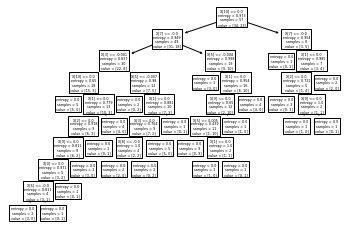

In [36]:
tree.plot_tree(dt)

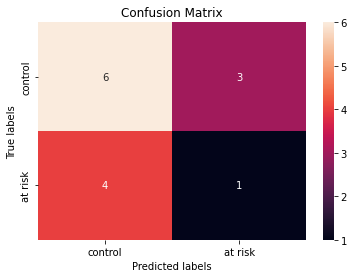

In [37]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [39]:
# with kfold cross validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = tree.DecisionTreeClassifier(max_depth=5)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    print(pred_values)
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

[0 1 0 0 1 0 0 1 1 1 0 0 0 0 0]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1]
[1 0 0 1 1 1 1 0 0 0 0 0 1 0]
[0 1 0 0 1 1 0 1 1 0 0 1 0 1]
[0 1 0 1 1 0 0 1 0 0 0 0 0 0]
accuracy of each fold - [0.5333333333333333, 0.5, 0.6428571428571429, 0.42857142857142855, 0.5]
Avg accuracy : 0.5209523809523808


# MLP

In [40]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier()
parameters = {'activation':('identity', 'relu', 'logistic', 'tanh'), 'alpha':[0.00001, 10], 'solver':('lbfgs','sgd', 'adam'),
              'learning_rate':('invscaling', 'adaptive'), 'max_iter': [4000,5000]}
clf = GridSearchCV(NN, parameters)
clf.fit(X_train, y_train)

NN = MLPClassifier(activation=clf.best_params_.get('activation'), alpha=clf.best_params_.get('alpha'), solver=clf.best_params_.get('solver'),
                  learning_rate=clf.best_params_.get('learning_rate'), max_iter=clf.best_params_.get('max_iter'))
NN.fit(X_train, y_train)
y_pred = NN.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

Accuracy: 0.643


/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [41]:
clf.best_params_

{'activation': 'tanh',
 'alpha': 1e-05,
 'learning_rate': 'adaptive',
 'max_iter': 4000,
 'solver': 'lbfgs'}

In [43]:
k = 5
kf = KFold(n_splits=k, shuffle = True, random_state=None)
model = NN
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    NN.fit(X_train,y_train)
    pred_values = NN.predict(X_test)
    print(pred_values)
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[1 0 1 0 0 1 0 1 0 1 1 1 0 1 0]


/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[0 0 0 0 0 0 0 1 1 1 1 1 0 0]


/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[1 0 0 1 0 0 0 1 0 0 0 0 0 0]
[1 0 1 0 0 1 0 1 0 1 0 1 1 0]
[0 0 1 0 1 0 1 0 0 0 0 0 0 0]
accuracy of each fold - [0.5333333333333333, 0.7142857142857143, 0.7142857142857143, 0.5, 0.5714285714285714]
Avg accuracy : 0.6066666666666667


/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
